# Image Steganography

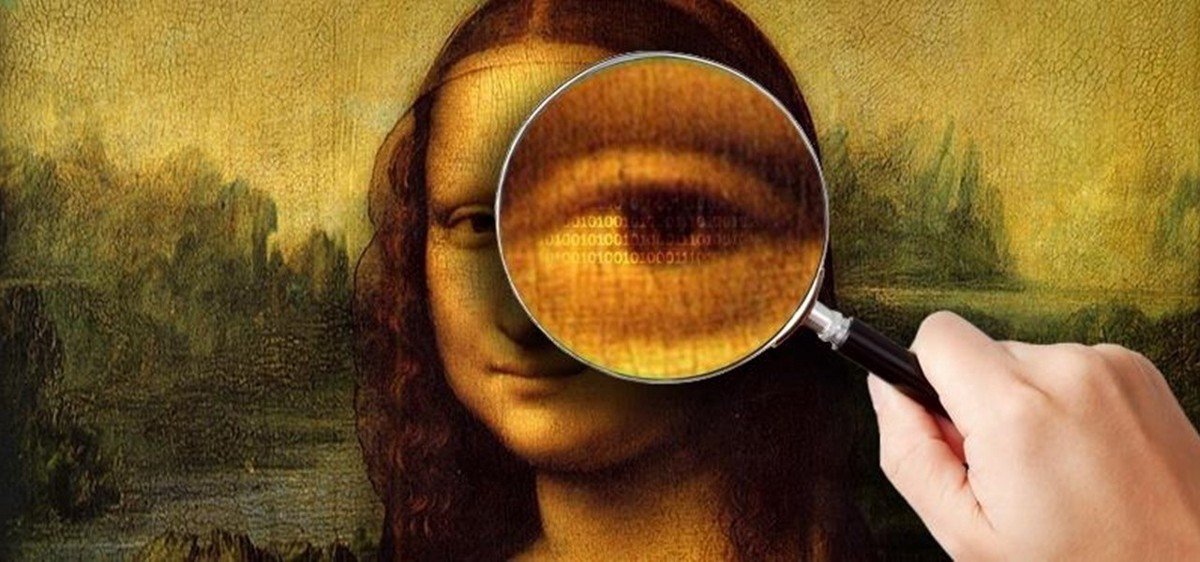

### Hiding data in image

## Steps included -> 

- Convert hidden message to binary 
- Extract the lowest bit plane
- Mix the decoded message into the lowest bit plane 
- Add the decode bit plane back to the original image 
- Decode the image

In [136]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt 

In [192]:
img = cv2.imread("dollar_img.tif")

(-0.5, 1191.5, 499.5, -0.5)

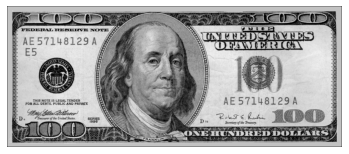

In [193]:
plt.imshow(img[:,:,::-1], cmap="gray")
plt.axis('off')

In [194]:
# we will be using any one channel (in this case, only blue channel)
b,g,r = cv2.split(img)

## Convert hidden message into binary 

In [195]:
def hidden_message_to_binary(hidden_message, end_character="!"):
    """
    Converts the hidden message to binary format
    hidden_message (string): the message to be encoded
    end character (character): the character which describes the end of sentence (Default is "!")
    """
    # end the end character 
    hidden_message = hidden_message + end_character
    
    # convert the characters to their ascii values 
    ascii_values = list(hidden_message.encode("ascii"))
    
    # convert the ascii values to binary representation
    hidden_message_binary = [np.binary_repr(ascii_code, width=8) for ascii_code in ascii_values]
    
    # join the elements in the list to form a string 
    hidden_message_binary = "".join([np.binary_repr(ascii_code, width=8) for ascii_code in ascii_values])
    
    # convert it to a numpy array of dtype "int64"
    hidden_message_binary= np.array(list(hidden_message_binary), dtype="int64")
    
    return hidden_message_binary

In [197]:
# test the above function

sample_hidden_message = "They are going to rob the bank"

binary_message = hidden_message_to_binary(sample_hidden_message)

print(binary_message)

[0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0
 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1
 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1
 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1
 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0
 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0
 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1]


In [198]:
print("Length of input sentence - ", len(sample_hidden_message))
print("Length of binary conversion - ", len(binary_message))

assert len(binary_message) == 8*(len(sample_hidden_message)+1) # +1 for end character

Length of input sentence -  30
Length of binary conversion -  248


## Extract the lowest bit plane

In [199]:
def bitPlaneSlicing(img, bit_plane):
    """
    img: gray scale image 
    bit_plane: sliced place given as output
          1 -> least significant bit plane 
          8 -> most significant bit plane
    """
    dec = np.binary_repr(img, width = 8)
    return int(dec[8-bit_plane])

bitPlaneSlicingVec = np.vectorize(bitPlaneSlicing)

In [200]:
# extracting the lowest bit plane out of the blue channel of the image
l_plane = bitPlaneSlicingVec(b, 1)

In [201]:
l_plane.shape

(500, 1192)

(-0.5, 1191.5, 499.5, -0.5)

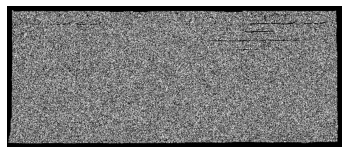

In [202]:
plt.imshow(l_plane, cmap="gray")
plt.axis('off')

## Mix the decoded message into the lowest bit plane

In [203]:
def add_code_to_bit_plane(bit_plane, binary_message):
    """
    Takes input as the bit plane and binary message
    and encodes the message to the bit plane. 
    
    Arguments:
        bit_plane (np.ndarray): the bit plane which is returned by the func bitPlaneSlicing
        binary message (np.ndarray): the binary form of hidden message as returned by 
        hidden_message_to_binary
    """
    bit_plane_flattened = bit_plane.flatten()
    len_binary_coded = len(binary_message)
    bit_plane_flattened[:len_binary_coded] = binary_message
    bit_plane_coded = bit_plane_flattened.reshape(bit_plane.shape)
    return bit_plane_coded

In [204]:
l_plane_coded = add_code_to_bit_plane(l_plane, binary_message)

In [205]:
l_plane_coded.shape

(500, 1192)

## Add the lowest bit plane back to the original image 

In [206]:
def add_bit_plane_back_to_image(img, bit_plane):
    #Iterate over each pixel and change pixel value to binary using np.binary_repr() and store it in a list.
    lst = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
             lst.append(np.binary_repr(img[i][j] ,width=8)) # width = no. of bits

    # We have a list of strings where each string represents binary pixel value. To extract bit planes we need to iterate over the strings and store the characters corresponding to bit planes into lists.
    # Multiply with 2^(n-1) and reshape to reconstruct the bit image.
    eight_bit_img = (np.array([int(i[0]) for i in lst],dtype = np.uint8) * 128).reshape(img.shape[0],img.shape[1])
    seven_bit_img = (np.array([int(i[1]) for i in lst],dtype = np.uint8) * 64).reshape(img.shape[0],img.shape[1])
    six_bit_img = (np.array([int(i[2]) for i in lst],dtype = np.uint8) * 32).reshape(img.shape[0],img.shape[1])
    five_bit_img = (np.array([int(i[3]) for i in lst],dtype = np.uint8) * 16).reshape(img.shape[0],img.shape[1])
    four_bit_img = (np.array([int(i[4]) for i in lst],dtype = np.uint8) * 8).reshape(img.shape[0],img.shape[1])
    three_bit_img = (np.array([int(i[5]) for i in lst],dtype = np.uint8) * 4).reshape(img.shape[0],img.shape[1])
    two_bit_img = (np.array([int(i[6]) for i in lst],dtype = np.uint8) * 2).reshape(img.shape[0],img.shape[1])
    
    final_image = eight_bit_img + seven_bit_img + six_bit_img + five_bit_img + four_bit_img + three_bit_img + two_bit_img + l_plane_coded.astype("uint8")
    return final_image


In [207]:
final_image_b = add_bit_plane_back_to_image(b, l_plane_coded)

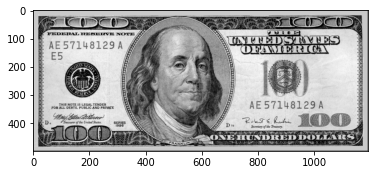

In [208]:
plt.imshow(final_image_b, cmap="gray")

In [209]:
final_image_bgr = cv2.merge((final_image_b, g, r))

In [210]:
cv2.imwrite("coded_image.png", final_image_bgr)

True

In [211]:
final_image_bgr.shape

(500, 1192, 3)

## Get message from the coded image

In [212]:
def binary_repr_to_ch(binary_array):
    binary_value = "".join(binary_array.astype('str'))
    ascii_code = int(binary_value, 2)
    character = chr(ascii_code)
    return character 

In [213]:
def get_message_from_plane(plane, end_character = "!"):
    plane_flatten = plane.flatten()
    plane_flatten = plane_flatten[:len(plane_flatten) - len(plane_flatten)%8]
    plane_reshaped = plane_flatten.reshape(-1, 8)

    sentence = []
    for binary_repr in plane_reshaped:
        character = binary_repr_to_ch(binary_repr)
        if character == end_character:
            break
        sentence.append(character)

    return "".join(sentence) 


In [214]:
def decode_image(image, end_character="!"):
    """
    image: single channel image, where message is being hidden in the
            lowest bit plane 
    end character: the character denoting the end of hidden message
    """
    first_channel, _, _ = cv2.split(image)
    lowest_bit_plane = bitPlaneSlicingVec(first_channel, 1)
    
    message = get_message_from_plane(lowest_bit_plane)
    
    return message
    

In [215]:
decode_image(final_image_bgr)

'They are going to rob the bank'

### Use the saved image

In [216]:
encoded_img = cv2.imread("coded_image.png")

In [217]:
encoded_img.shape

(500, 1192, 3)

In [218]:
decode_image(encoded_img)

'They are going to rob the bank'

# Running through Script

The code has been compiled into module to provide a better end to end run. 

To Encode message in Image - 

`python encode.py -i image_path -m "message to be encoded" -s save_location`

To decode the hidden image - 

`python decode.py image_path`

To show output on image 

`python decode.py image_path --show`
